1. 데이터 로드 및 전처리 (Device: cuda)
2. 데이터 분할 (Train / Val / Test)...

3. Grid Search 시작 (최적의 파라미터 찾기)...
   - 총 8개의 조합을 실험합니다.

[실험 1/8] Params: {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.001}
   -> Validation MSE: 0.6746
   *** New Best Model Found! ***

[실험 2/8] Params: {'hidden_dim': 64, 'num_layers': 1, 'learning_rate': 0.0005}
   -> Validation MSE: 0.9033

[실험 3/8] Params: {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.001}
   -> Validation MSE: 0.5212
   *** New Best Model Found! ***

[실험 4/8] Params: {'hidden_dim': 64, 'num_layers': 2, 'learning_rate': 0.0005}
   -> Validation MSE: 0.6982

[실험 5/8] Params: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.001}
   -> Validation MSE: 0.5853

[실험 6/8] Params: {'hidden_dim': 128, 'num_layers': 1, 'learning_rate': 0.0005}
   -> Validation MSE: 0.8351

[실험 7/8] Params: {'hidden_dim': 128, 'num_layers': 2, 'learning_rate': 0.001}
   -> Validation MSE: 0.5482

[실험 8/8] Params: {'hidden_dim': 128, 'num_layers': 2, '

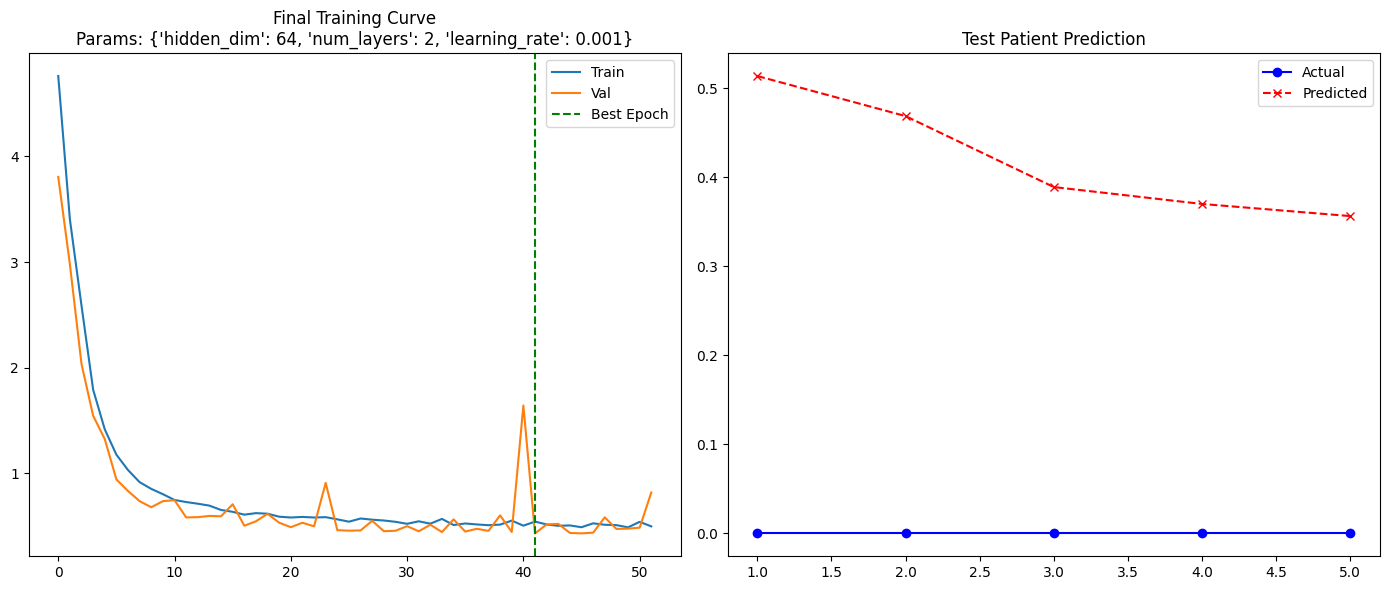

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import os

# ---------------------------------------------------------
# 1. 설정 및 데이터 전처리
# ---------------------------------------------------------
input_csv = 'FINAL_CANCER_DATASET_LANDMARK.csv'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"1. 데이터 로드 및 전처리 (Device: {device})")

try:
    df = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"오류: '{input_csv}' 파일을 찾을 수 없습니다.")
    exit()

df = df[df['segment_num'] <= 5].copy()
df['log_mme'] = np.log1p(df['total_opioid_mme'])

# Feature 선택 & Scaling
ignore_cols = ['hadm_id', 'segment_period', 'log_mme']
feature_cols = [c for c in df.columns if c not in ignore_cols]

scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

# ---------------------------------------------------------
# 2. 환자 기준 데이터 분할
# ---------------------------------------------------------
print("2. 데이터 분할 (Train / Val / Test)...")
unique_ids = df['hadm_id'].unique()
train_ids, temp_ids = train_test_split(unique_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

def create_sequences_tensor(df, target_ids):
    df_filtered = df[df['hadm_id'].isin(target_ids)]
    grouped = df_filtered.groupby('hadm_id')
    seqs, targets = [], []
    for _, group in grouped:
        group = group.sort_values('segment_num')
        if len(group) < 2: continue
        seq_x = group[feature_cols].iloc[:-1].values
        seq_y = group['log_mme'].iloc[1:].values
        seqs.append(torch.tensor(seq_x, dtype=torch.float32))
        targets.append(torch.tensor(seq_y, dtype=torch.float32))
    return seqs, targets

train_seqs, train_y = create_sequences_tensor(df, train_ids)
val_seqs, val_y = create_sequences_tensor(df, val_ids)
test_seqs, test_y = create_sequences_tensor(df, test_ids)

# Dataset Class
class LandmarkDataset(Dataset):
    def __init__(self, seqs, targets):
        self.seqs = seqs
        self.targets = targets
    def __len__(self): return len(self.seqs)
    def __getitem__(self, idx): return self.seqs[idx], self.targets[idx]

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    lengths = torch.tensor([len(x) for x in inputs])
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=-999)
    return inputs_padded, targets_padded, lengths

# DataLoader (Batch Size 128 적용)
BATCH_SIZE = 128
train_loader = DataLoader(LandmarkDataset(train_seqs, train_y), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(LandmarkDataset(val_seqs, val_y), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(LandmarkDataset(test_seqs, test_y), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# ---------------------------------------------------------
# 3. 모델 정의
# ---------------------------------------------------------
class CumulativeMMEPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.2):
        super(CumulativeMMEPredictor, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x, lengths):
        packed_x = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, _ = self.gru(packed_x)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        return self.fc(out).squeeze(-1)

# ---------------------------------------------------------
# 4. Grid Search
# ---------------------------------------------------------
print("\n3. Grid Search 시작 (최적의 파라미터 찾기)...")

param_grid = {
    'hidden_dim': [64, 128],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_val_loss = float('inf')
best_params = None
search_epochs = 15 # 탐색용 짧은 에포크

print(f"   - 총 {len(combinations)}개의 조합을 실험합니다.")

for i, params in enumerate(combinations):
    print(f"\n[실험 {i+1}/{len(combinations)}] Params: {params}")

    model = CumulativeMMEPredictor(
        input_dim=len(feature_cols),
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers']
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss(reduction='none')

    # Short Training
    model.train()
    for epoch in range(search_epochs):
        for x, y, lens in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x, lens)
            mask = (y != -999).float()
            loss = (criterion(preds, y) * mask).sum() / mask.sum()
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    val_loss, val_cnt = 0, 0
    with torch.no_grad():
        for x, y, lens in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x, lens)
            mask = (y != -999).float()
            loss = (criterion(preds, y) * mask).sum() / mask.sum()
            val_loss += loss.item() * mask.sum().item()
            val_cnt += mask.sum().item()

    avg_val_loss = val_loss / val_cnt
    print(f"   -> Validation MSE: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_params = params
        print("   *** New Best Model Found! ***")

print("=" * 50)
print(f"Grid Search 완료! 최적 파라미터: {best_params}")
print("=" * 50)

# ---------------------------------------------------------
# 5. 최적 모델 최종 학습 (Early Stopping 적용)
# ---------------------------------------------------------
print("\n4. 최적 파라미터로 최종 학습 (Early Stopping: Patience 3)...")

final_epochs = 200
patience = 10
patience_counter = 0
best_model_loss = float('inf')
checkpoint_path = 'best_model_checkpoint.pth'

best_model = CumulativeMMEPredictor(
    input_dim=len(feature_cols),
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers']
).to(device)

optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss(reduction='none')

train_losses, val_losses = [], []

for epoch in range(final_epochs):
    # Train
    best_model.train()
    epoch_loss, cnt = 0, 0
    for x, y, lens in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = best_model(x, lens)
        mask = (y != -999).float()
        loss = (criterion(preds, y) * mask).sum() / mask.sum()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * mask.sum().item()
        cnt += mask.sum().item()
    train_loss = epoch_loss / cnt
    train_losses.append(train_loss)

    # Validation
    best_model.eval()
    val_loss, val_cnt = 0, 0
    with torch.no_grad():
        for x, y, lens in val_loader:
            x, y = x.to(device), y.to(device)
            preds = best_model(x, lens)
            mask = (y != -999).float()
            loss = (criterion(preds, y) * mask).sum() / mask.sum()
            val_loss += loss.item() * mask.sum().item()
            val_cnt += mask.sum().item()
    current_val_loss = val_loss / val_cnt
    val_losses.append(current_val_loss)

    print(f"Epoch {epoch+1}/{final_epochs} | Train: {train_loss:.4f} | Val: {current_val_loss:.4f} | Patience: {patience_counter}/{patience}")

    # [Early Stopping Logic]
    if current_val_loss < best_model_loss:
        best_model_loss = current_val_loss
        patience_counter = 0
        torch.save(best_model.state_dict(), checkpoint_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\n[Early Stopping] {patience}회 연속 성능 개선이 없어 학습을 종료합니다.")
            break

# ---------------------------------------------------------
# 6. 최종 테스트 및 시각화
# ---------------------------------------------------------
print("\n5. 최종 Test Set 평가...")

# Best Checkpoint Load
best_model.load_state_dict(torch.load(checkpoint_path))
best_model.eval()

test_loss, test_cnt = 0, 0
with torch.no_grad():
    for x, y, lens in test_loader:
        x, y = x.to(device), y.to(device)
        preds = best_model(x, lens)
        mask = (y != -999).float()
        loss = (criterion(preds, y) * mask).sum() / mask.sum()
        test_loss += loss.item() * mask.sum().item()
        test_cnt += mask.sum().item()

print(f"Final Test MSE (Log Scale): {test_loss/test_cnt:.4f}")

# 시각화
plt.figure(figsize=(14, 6))
# (1) Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.axvline(x=len(train_losses)-patience-1, color='g', linestyle='--', label='Best Epoch')
plt.title(f'Final Training Curve\nParams: {best_params}')
plt.legend()

# (2) Test Sample
inputs, targets, lens = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
with torch.no_grad():
    preds = best_model(inputs, lens)

idx = torch.argmax(lens).item()
valid_len = lens[idx].item()
true_traj = np.expm1(targets[idx, :valid_len].cpu().numpy())
pred_traj = np.expm1(preds[idx, :valid_len].cpu().numpy())

plt.subplot(1, 2, 2)
plt.plot(range(1, valid_len+1), true_traj, 'b-o', label='Actual')
plt.plot(range(1, valid_len+1), pred_traj, 'r--x', label='Predicted')
plt.title('Test Patient Prediction')
plt.legend()
plt.tight_layout()
plt.savefig('final_best_result.png')
print("[완료] 결과 저장됨: final_best_result.png")